<a href="https://colab.research.google.com/github/juancaalcaraz/practicaML/blob/main/BackPropagationNumpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import struct

def load_mnist(path, kind='trian'):
  """Cargar mnist desde el path"""
  labels_path = os.path.join(path, '%s-labels.idx1-ubyte'%kind)
  images_path = os.path.join(path, '%s-images.idx3-ubyte'%kind)

  with open(labels_path, 'rb') as lbpath :
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype= np.uint8)
  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    images = np.fromfile(imgpath, dtype= np.uint8).reshape(len(labels), 784)
    images = images / 255. #El libro procesa las imagenes de esta forma ((images / 255.) - .5) *2

  return images, labels

### La función devuelve dos matrices, la primera es una matriz numpy dimensional $n$ x $m$(images), donde $n$ es el número de muestras y $m$ es el número de características(aquí pixeles).  

In [ ]:
X_train, y_train = load_mnist('', kind='train')
print('Filas: %d, columnas: %d' % (X_train.shape[0], X_train.shape[1]))

Filas: 60000, columnas: 784


In [ ]:
X_test, y_test = load_mnist('', kind='t10k')
print('Filas: %d, columnas: %d' % (X_test.shape[0], X_test.shape[1]))

Filas: 10000, columnas: 784


### Vamos a visualizar un par de ejemplos de estas imágenes

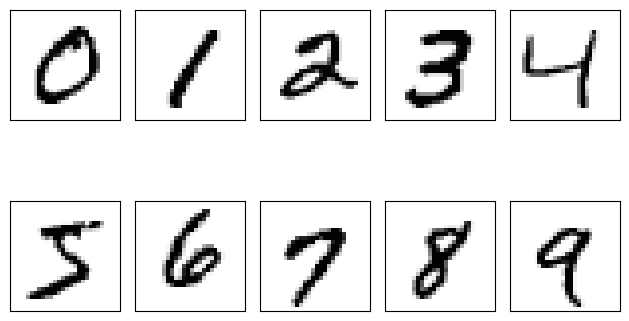

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Vamos a visualizar disitintos ejemplos del mismo número para ver que tan distita es la escritura.

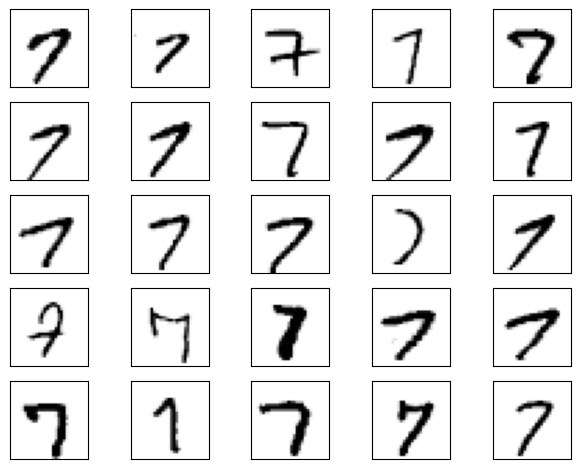

In [ ]:
fix, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
  img = X_train[y_train == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Vamos a guardar los datos en una matriz de numpy para procesarlos en otro momento.

In [ ]:
np.savez_compressed('mnist_scaled.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test= y_test)


In [1]:
import numpy as np
# Cargamos la matriz Numpy
mnist = np.load('mnist_scaled.npz')

In [ ]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [ ]:
# para acceder a una parte especifica de la matriz
#X_train = mnist['X_train']

## Mediante comprensión de listas recuperamos los datos de la siguiente forma:  

In [2]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

#**Implementar un perceptrón multicapa desde cero**  

## Vamos a implementar un M.L.P. con una capa de entrada, una capa oculta y una de salida para clasificar las imágenes en el conjunto de datos MNIST.  

In [3]:
import numpy as np
import sys

class NeuralNetMLP(object):
  """
  Feedforward neural network / multi-layer preceptron classsifier.

  parameters
  -----------
  n_hiden : int (default: 30)
    number of hidden units.
  l2 : float (deafault: 0.)
    lambda value for L2-regularization.
    No regularization if l2 = 0. (default)
  epochs: int (default: 100)
    number of passes over the training set.
  eta: float (default: 0.001)
    learning rate
  shuffle : bool (default: True)
    shuffles training data every epoch
    if True to prevent cirlces.
  minibatch_size : int (default: 1)
    number of training examples per minibatch.
  seed : int (default: None)
    Random seed for initializing weights and shuffling.

  Attributes
  -----------
  eval_ : dict
    Dictionary collecting the cost, training accuracy,
    and validation accuracy for each epoch during training.
  """
  def __init__(self, n_hidden=30, l2=0., epochs=100, eta= .001, shuffle=True, minibatch_size= 1, seed = None):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.eta = eta
    self.epochs = epochs
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size

  def _onehot(self, y, n_classes):
    """
    Encode labels into one-hot representation

    Parameters
    -----------
    y : array, shape = [n_samples]
      Target values.
    Returns
    -----------
    onehot : array, shape = (n_samples, n_labels)
    """
    onehot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y.astype(int)):
      onehot[val, idx] = 1.
    return onehot.T

  def _sigmoid(self, z):
    """
    Compute logistic function (sigmoid)

    Parameters
    -----------
    z : array
      Input
    """
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

  def _forward(self, X):
    """
    Compute forward propagation step
    """
    # paso 1: entrada de red de la capa oculta
    # [n_samples, n_features] dot [n_fetures, n_hidden]
    # -> [n_samples, n_hidden]
    z_h = np.dot(X, self.w_h) + self.b_h

    # Paso 2: activacion de la capa oculta.
    a_h = self._sigmoid(z_h)

    # Paso 3: entrada de red de la capa de salida.
    # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
    # -> [n_samples, n_classlabels]

    z_out = np.dot(a_h, self.w_out) + self.b_out

    # paso 4: acticaión de la capa de salida.
    a_out = self._sigmoid(z_out)
    return z_h, a_h, z_out, a_out

  def _compute_cost(self, y_enc, output):
    """
    Compute cost function.

    Parameters
    -----------
    y_enc : array, shape = (n_samples, n_labels)
      one-hot encoded class labels.
    output : array, shape = [n_samples, n_output_units]
      Activation of the output layer (forward propagation)

    Returns
    -----------
    cost : float
      regularized cost
    """
    L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
    term1 = -y_enc * np.log(output)
    term2 = (1. - y_enc) * np.log(1. - output)
    cost = np.sum(term1 - term2) + L2_term
    return cost

  def predict(self, X):
    """
    Predict class labels

    Parameters
    -----------
    X : array, shape = [n_samples, n_features]
      Input layer with original features.
    Returns
    -----------
    y_pred : array, shape = [n_samples]
      Predicted class labels
    """
    z_h, a_h, z_out, a_out = self._forward(X)
    y_pred = np.argmax(z_out, axis=1)
    return y_pred

  def fit(self, X_train, y_train, X_valid, y_valid):
    """
    Learn weights from training data.
    Parameters
    -----------
    X_train : array, shape = [n_samples, n_features]
      Input layer with original features.
    y_train : array, shape = [n_samples]
      Target class labels.
    X_valid : array, shape = [n_samples, n_features]
      Sample features for validation during training
    y_valid : array, shape = [n_samples]
      Sample labels for validation during training
    Returns
    -----------
    self
    """
    n_output = np.unique(y_train).shape[0] # numero de etiquetas de clases.
    n_features = X_train.shape[1]

    ##########################
    # Inicialización del peso
    ##########################

    # pesos para entrada -> oculta.
    self.b_h = np.zeros(self.n_hidden)
    #self.w_h = self.random.normal(loc= 0.0, scale=0.1, size=(n_features, self.n_hidden))
    self.w_h = self.random.normal(loc=0.0, scale=np.sqrt(2 / (n_features + self.n_hidden)), size=(n_features, self.n_hidden))
    # pesos para oculta -> salida.
    self.b_out = np.zeros(n_output)
    #self.w_out = np.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
    self.w_out = self.random.normal(loc=0.0, scale=np.sqrt(2 / (self.n_hidden + n_output)), size=(self.n_hidden, n_output))

    epoch_strlen = len(str(self.epochs)) # para un formato progresivo.
    self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

    y_train_enc = self._onehot(y_train, n_output)
    # Iterar sobre épocas de entrenamiento.
    for i in range(self.epochs):
      # iterar sobre minilotes.
      indices = np.arange(X_train.shape[0])
      if self.shuffle:
        self.random.shuffle(indices)
      for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
        batch_idx = indices[start_idx: start_idx + self.minibatch_size]
        #forward propagation.
        # propagación hacia adelante
        z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

        ##########################
        # propagación hacia atrás.
        # backpropagation
        ##########################
        # [n_samples, n_classlabels]
        sigma_out = a_out - y_train_enc[batch_idx]

        # [n_samples, n_hidden]
        sigmoid_derivate_h = a_h * (1. - a_h)

        # [n_samples, n_classslabels] dot [n_classlabels, n_hidden]
        # -> [n_samples, n_hidden]
        sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivate_h)

        # [n_features, n_samples] dot [n_samples, n_hidden]
        # -> [n_features, n_hidden]
        grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
        grad_b_h = np.sum(sigma_h, axis=0)

        # [n_hidden, n_samples] dot [n_samples, n_classlabels]
        # -> [n_hidden, n_classlebels]
        grad_w_out = np.dot(a_h.T, sigma_out)
        grad_b_out = np.sum(sigma_out, axis=0)

        # Regularización y actualización de pesos.
        delta_w_h = (grad_b_h + self.l2*self.w_h)
        delta_b_h = grad_b_h # El sesgo no esta regularizado.
        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h

        delta_w_out = (grad_w_out + self.l2*self.w_out)
        delta_b_out = grad_b_out
        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out

      ##############
      # Evaluación
      ##############

      # Evaluación después de cada época durante el entrenamiento.
      z_h, a_h, z_out, a_out = self._forward(X_train)
      cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)

      train_acc = ((np.sum(y_train == y_train_pred)).astype(float) / X_train.shape[0])
      valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0])

      sys.stderr.write('\r%0*d/%d | Cost: %.2f | Train/Valid Acc.: %.2f%%/%.2f%%'%
                       (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc * 100))

      sys.stderr.flush()

      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)
    return self

### Vamos a inicializar un nuevo MLP 784-200-10 una red neuronal con 784 unidades de entrada(n_features), 200 unidades ocultas(n_hidden) y 10 unidades de salida(n_output) :

In [4]:
nn = NeuralNetMLP(n_hidden=200,
                  l2=0.001,
                  epochs=200,
                  eta=0.0001,
                  minibatch_size=100,
                  shuffle=True,
                  seed= 42)

### Resumen de estos parámetros.
1. l2: Parámetro λ para la regularización L2 para reducir el grado de sobreajuste.
2. epochs: Número de pasos sobre el conjunto de entrenamiento.
3. eta: Tasa de aprendizaje $n$.
4. shuffle: Para mezclar el conjunto de entrenamiento antes de cada época y prevenir que el algoritmo se quede estancado haciendo círculos.
5. seed: Disposición aleatoria para mezclar y ponderar la inicialización.
6. minibatch_size: Número de muestras de entrenamiento en cada minilote. Para conseguir un aprendizage más rápido, el gradiente se calcula para cada minilote por separado.
### A continuación entrenamos el MLP con el conjunto de datos MNIST.  

In [ ]:
print(len(X_train))
print(len(y_train))

60000
60000


In [ ]:
#X_train_normalized = X_train / 255.0

In [5]:
nn.fit(X_train=X_train[:55000],
       y_train= y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

200/200 | Cost: 62203.46 | Train/Valid Acc.: 84.40%/88.64%

### Vamos a graficar el coste sobre 200 épocas.

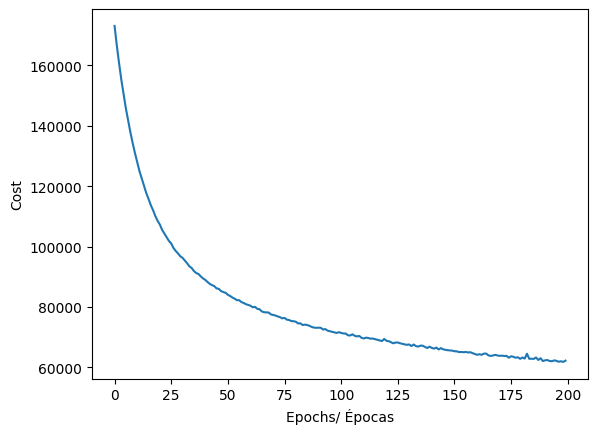

In [6]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs/ Épocas')
plt.show()

### Como podemos ver el coste disminuye sustancialmente durante las primeras 100 épocas y parece que lentamente converge en las últimas 100.


### Ahora veamos el enrenamiento y la precisión de la validación.

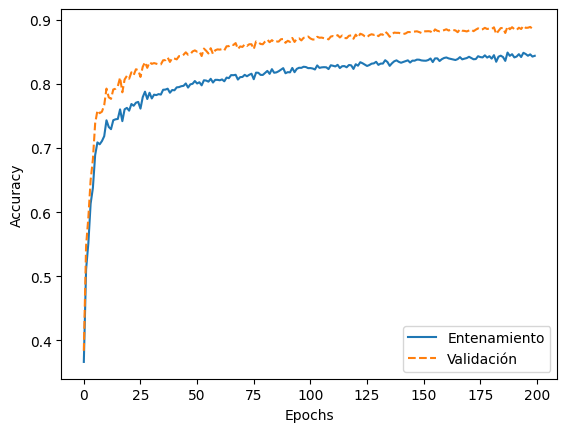

In [7]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='Entenamiento')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='Validación', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show()

### Observamos una mejor puntuación en la validación que en el entrenamiento.

In [8]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(float) / X_test.shape[0])
print('Precisión de entrenamiento: %.2f%%' % (acc*100))

Precisión de entrenamiento: 85.39%


### Echaremos un vistazo a algunas de las imágenes con las que lucha nuestro MLP.

In [9]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

### Ahora vamos a ver una matriz de 5x5 donde el primer número en los subtitulos indica el indice de representación, el segundo representa la etiqueta de clase verdadera(t) y el tercero sigifica la etiqueta de clase predicha(p)

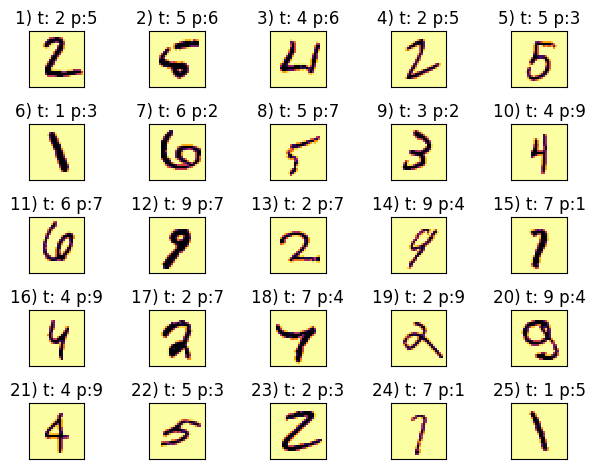

In [17]:
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex= True,
                       sharey= True)
ax = ax.flatten()
for i in range(25):
  img = miscl_img[i].reshape(28, 28)
  ax[i].imshow(img,
               cmap='inferno_r',
               interpolation='nearest')
  ax[i].set_title('%d) t: %d p:%d'%(i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Ahora graficamos las etiquetas donde predijo correctamente nuestro MLP.

In [18]:
pred_img = X_test[y_test == y_test_pred][:25]
correct_lab = y_test[y_test == y_test_pred][:25]
pred_lab = y_test_pred[y_test == y_test_pred][:25]

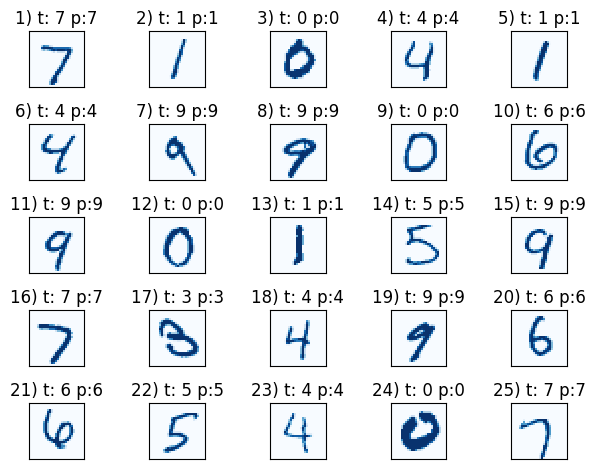

In [25]:
fig, ax = plt.subplots(nrows=5,
                       ncols=5,
                       sharex= True,
                       sharey= True)
ax = ax.flatten()
for i in range(25):
  img = pred_img[i].reshape(28, 28)
  ax[i].imshow(img,
               cmap='Blues',
               interpolation='nearest')
  ax[i].set_title('%d) t: %d p:%d'%(i+1, correct_lab[i], pred_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()